#Music Note Classification

dataset from: https://www.kaggle.com/kishanj/music-notes-datasets?select=data1.csv

In [73]:
# Authors:
# Princeton Ferro <pcf252@nyu.edu>
# Bohan Zhang <bz771@nyu.edu>
# Yuteng Zhang <yz7436@nyu.edu>

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import cv2

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # for debugging only

print('PyTorch version:', torch.__version__)
print('PyTorch Vision version:', torchvision.__version__)

#dir = 'musicdata'
dir = 'cv/cv_project'
mounted = False

try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  mounted = True
  # %cd /content/drive/'My Drive'/muscima/
  os.chdir('/content/drive/My Drive')
  dir = os.path.join(os.getcwd(), dir)
except Exception as err:
  print('warning: will not use Google Drive', file=sys.stderr)

try:
  os.chdir(dir)
except Exception as err:
  print(f'ERROR: could not find directory {dir}', file=sys.stderr)
  sys.exit(1)

print('current dir is', os.getcwd())

PyTorch version: 1.10.0+cu111
PyTorch Vision version: 0.11.1+cu111
Mounted at /content/drive
current dir is /content/drive/My Drive/cv/cv_project


In [74]:
# set hyperparameters and configuration
batch_size = 32
momentum = 0.9
lr = 0.01
epochs = 20
log_interval = 10
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'
print('will use', device, 'for training')
  # unused, but see https://github.com/pytorch/pytorch/issues/40403
  #torch.multiprocessing.set_start_method('spawn')

will use cuda for training


## Music Note classification

### Music Noteheads Dataset

Eight note:


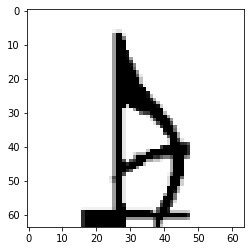

Half note:


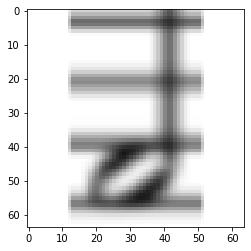

Quarter note:


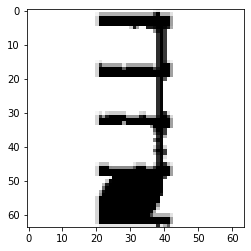

Sixteenth note:


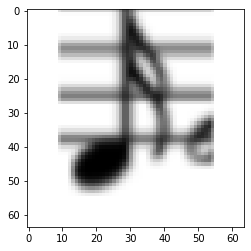

Whole note:


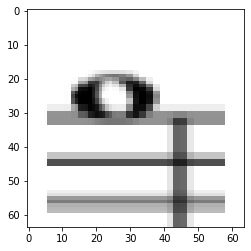

There are 231 training and 28 evaluation samples


In [75]:
# load dataset for note classification

# Kaggle Notes dataset is in ./Notes
# Notes with stafflines dataset is in ./NotesWithStafflines

# F.center_crop but with configurable fill
def center_crop(img: torch.Tensor, output_size, fill):
    """
    See https://github.com/pytorch/vision/blob/0b02d420f76615fce15f04a1433cc89d30382e34/torchvision/transforms/functional.py#L499
    """
    if isinstance(output_size, int):
        output_size = (int(output_size), int(output_size))
    elif isinstance(output_size, (tuple, list)) and len(output_size) == 1:
        output_size = (output_size[0], output_size[0])

    image_width, image_height = transforms.functional.get_image_size(img)
    crop_height, crop_width = output_size

    if crop_width > image_width or crop_height > image_height:
        padding_ltrb = [
            (crop_width - image_width) // 2 if crop_width > image_width else 0,
            (crop_height - image_height) // 2 if crop_height > image_height else 0,
            (crop_width - image_width + 1) // 2 if crop_width > image_width else 0,
            (crop_height - image_height + 1) // 2 if crop_height > image_height else 0,
        ]
        img = transforms.functional.pad(img, padding_ltrb, fill=fill)
        image_width, image_height = transforms.functional.get_image_size(img)
        if crop_width == image_width and crop_height == image_height:
            return img

    crop_top = int(round((image_height - crop_height) / 2.0))
    crop_left = int(round((image_width - crop_width) / 2.0))
    return transforms.functional.crop(img, crop_top, crop_left, crop_height, crop_width)

def _setup_size(size, error_msg):
    """
    See https://github.com/pytorch/vision/blob/0b02d420f76615fce15f04a1433cc89d30382e34/torchvision/transforms/transforms.py#L1801
    """
    if isinstance(size, int):
        return int(size), int(size)

    if isinstance(size, (tuple, list)) and len(size) == 1:
        return size[0], size[0]

    if len(size) != 2:
        raise ValueError(error_msg)

    return size

class CenterCropAndResize(torch.nn.Module):
    """
    1. Crops the image in the center to be square, filling in with {fill}.
    2. Resizes the image to {size} .
    Based on https://github.com/pytorch/vision/blob/0b02d420f76615fce15f04a1433cc89d30382e34/torchvision/transforms/transforms.py#L355
    """

    def __init__(self, size, fill):
        super().__init__()
        self.size = _setup_size(size, error_msg="Please provide only two dimensions (h, w) for size.")
        self.fill = fill

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be cropped.
        Returns:
            PIL Image or Tensor: Cropped image.
        """
        #print('img size =', img.size())
        cropped = center_crop(img, max(img.size()), self.fill)
        #print('cropped size =', cropped.size())
        return transforms.functional.resize(cropped, self.size)

    def __repr__(self):
        return self.__class__.__name__ + f"(size={self.size},fill={self.fill})"

image_transforms = transforms.Compose([
  transforms.ToTensor(),
  CenterCropAndResize(64, 1)
])
image_dataset = datasets.ImageFolder(os.path.join(dir, 'NotesWithStafflines'), transform=image_transforms)

# DEBUG: show an image from each class
class_indices = {}
for i, target in enumerate(image_dataset.targets):
  if target not in class_indices:
    class_indices[target] = []
  class_indices[target].append(i) 

plt.figure()
for c, indices in class_indices.items():
  i = np.random.choice(indices)
  target = image_dataset.targets[i]
  image, _ = image_dataset[i]
  print(image_dataset.classes[target], 'note:')
  plt.imshow(image.permute(1, 2, 0))
  plt.pause(0.001)
plt.show()

# Now, take [train_fraction*100] percentage of each class for training data,
# and leave the rest for testing data.
train_fraction = 0.9

train_indices = []
test_indices = []

for _, indices in class_indices.items():
  num_train = int(train_fraction * len(indices))
  train_is, test_is = torch.utils.data.random_split(indices, [num_train, len(indices) - num_train])
  train_indices += list(train_is)
  test_indices += list(test_is)

train_dataset = torch.utils.data.Subset(image_dataset, train_indices)
test_dataset = torch.utils.data.Subset(image_dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=True)

print('There are', len(train_dataset), 'training and', len(test_dataset), 'evaluation samples')

# nclasses = len(class_indices) + 1 # for background
nclasses = len(class_indices)


#### Notehead CNN

In [76]:
# CNN to classify notes

imagewidth = 64

class NotesCNN(nn.Module):
  def __init__(self):
    super(NotesCNN, self).__init__()
    self.out_channels = nclasses  # used by later R-CNN

    self.conv1 = nn.Conv2d(3, imagewidth, kernel_size=3)
    self.conv1_max_pool2d = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(imagewidth, 128, kernel_size=3)
    self.conv2_drop = nn.Dropout2d()
    self.conv2_max_pool2d = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=2)
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
    self.conv5 = nn.Conv2d(256, 256, kernel_size=3)
    self.conv6 = nn.Conv2d(256, 256, kernel_size=3)
    self.conv7 = nn.Conv2d(256, 256, kernel_size=2)
    self.conv8 = nn.Conv2d(256, 256, kernel_size=2)
    self.batchnorm = nn.BatchNorm2d(256)
    self.conv8_drop = nn.Dropout2d()
    self.conv8_max_pool2d = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(1024, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, nclasses)

  def forward(self, x):
    x = torch.tanh(self.conv1_max_pool2d(self.conv1(x)))
    x = torch.tanh(self.conv2_max_pool2d(self.conv2_drop(self.conv2(x))))
    x = torch.tanh(self.conv3(x))
    x = torch.tanh(self.conv4(x))
    x = torch.tanh(self.conv5(x))
    x = torch.tanh(self.conv6(x))
    x = torch.tanh(self.conv7(x))
    x = torch.tanh(self.conv8(x))
    x = torch.tanh(self.batchnorm(self.conv8_max_pool2d(self.conv8_drop(self.conv8(x)))))
    x = x.view(-1, 1024)
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x,dim=1)


#### Train Notehead CNN

In [77]:

avg_loss = []
validation_accuracy = []

def train_one_epoch(model, optimizer, train_loader, device, epoch, log_interval):
  # visualize first convolutional layer
  #for m in notes_cnn.modules():
  #  if isinstance(m, nn.Conv2d):
  #    data_img = torchvision.utils.make_grid(m.weight.cpu().detach())
  #    data_img = data_img / 2 + 0.5
  #    plt.imshow(np.transpose(data_img.numpy(), (1, 2, 0)))
  #    plt.show()
  #    break     # only visualize first layer
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    if isinstance(target, torch.Tensor):
      target = target.to(device)
    else:
      for key in target:
        target[key] = target[key].to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

def validate(model, test_loader):
  model.eval()
  validation_loss = 0
  correct = 0
  for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  validation_loss /= len(test_loader.dataset)
  print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
    validation_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
  avg_loss.append(validation_loss)
  validation_accuracy.append(float(correct) / len(test_loader.dataset))
  return float(correct) / len(test_loader.dataset)

In [27]:
notes_cnn = NotesCNN().to(device)

print('training', notes_cnn.__class__.__name__, 'model on', device)
summary(notes_cnn, (3, 64, 64))

notes_cnn_optimizer = optim.SGD(notes_cnn.parameters(), lr=lr, momentum=momentum)
notes_cnn_lr_scheduler = torch.optim.lr_scheduler.StepLR(notes_cnn_optimizer,
                                                            step_size=40,
                                                            gamma=0.2)

training_accuracies = []

# NOTE: the first epoch will be really slow because the images are loaded in 
#       memory on demand. Subsequent epochs will be really fast. The whole time
#       to train will be around 5 min.
for epoch in range(100):
  train_one_epoch(notes_cnn, notes_cnn_optimizer, train_loader, device, epoch, 10)
  notes_cnn_lr_scheduler.step()
  accuracy = validate(notes_cnn, test_loader)
  training_accuracies.append(accuracy)
  model_file = 'notes_model.pth'
  torch.save(notes_cnn.state_dict(), model_file)
  print('\nSaved model to ' + model_file + '.')

training NotesCNN model on cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           1,792
         MaxPool2d-2           [-1, 64, 31, 31]               0
            Conv2d-3          [-1, 128, 29, 29]          73,856
         Dropout2d-4          [-1, 128, 29, 29]               0
         MaxPool2d-5          [-1, 128, 14, 14]               0
            Conv2d-6          [-1, 128, 13, 13]          65,664
            Conv2d-7          [-1, 256, 11, 11]         295,168
            Conv2d-8            [-1, 256, 9, 9]         590,080
            Conv2d-9            [-1, 256, 7, 7]         590,080
           Conv2d-10            [-1, 256, 6, 6]         262,400
           Conv2d-11            [-1, 256, 5, 5]         262,400
           Conv2d-12            [-1, 256, 4, 4]         262,400
        Dropout2d-13            [-1, 256, 4, 4]               0
       

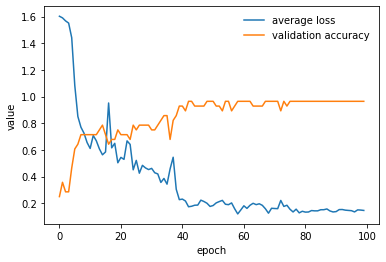

In [28]:
# print the prediction
plt.plot(avg_loss, label='average loss')
plt.plot(validation_accuracy, label='validation accuracy')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('value')
plt.show()

## Object Detection

In [78]:
# maximum number of staffline positions above middle C (staffline position 0)
num_stafflines = 13   # up to G5

 ### Random Music Dataset

In [6]:
# random dataset for notes detection
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

def random_music(width:int=256, height:int=128, num_chords:int=4):
    image = [np.ones((height, width)) for _ in range(3)]
    bboxes = []
    labels = []

    def putpixel(image, x, y, r, g, b):
        image[0][y, x] = r
        image[1][y, x] = g
        image[2][y, x] = b

    padding_x = int(width * 0.1)

    # draw staves
    staves_vspacing = 10
    staves_vbegin = int(height * 0.5 - 2*staves_vspacing)
    staves_vend = staves_vbegin + 5*staves_vspacing
    for y in range(staves_vbegin, staves_vend, staves_vspacing):
        for x in range(padding_x, width - padding_x):
            putpixel(image, x, y, 0, 0, 0)

    # generate white keys from 0 to 12
    # TODO: accidentals?

    max_pitch = min(num_stafflines, 12)
    def random_chord(notehead_type):
        chord = []
        for i in range(np.random.randint(1, 5)):
            if i > 0:
                chord.append((chord[i-1] + np.random.randint(2, 4)) % max_pitch)
            else:
                chord.append(np.random.randint(0, 6))
        return (sorted(chord), notehead_type)

    chords = [random_chord('quarter') for _ in range(num_chords)]

    def draw_notehead(image, x, y, radius, notehead_type):
      if notehead_type == 'quarter' or \
         notehead_type == 'eighth' or \
         notehead_type == 'sixteenth':
        # draw circle
        for x in range(-ceil(radius*1.5), ceil(radius*1.5)):
            for y in range(-ceil(radius*1.5), ceil(radius*1.5)):
                if x*x + y*y <= radius*radius:
                    putpixel(image, key_x + x, key_y + y, 0, 0, 0)
      elif notehead_type == 'half':
        # draw circle
        for x in range(-ceil(radius*1.5), ceil(radius*1.5)):
            for y in range(-ceil(radius*1.5), ceil(radius*1.5)):
                if (radius*0.8)*(radius*0.8) <= x*x + y*y <= radius*radius:
                    putpixel(image, key_x + x, key_y + y, 0, 0, 0)
      elif notehead_type == 'whole':
        # draw circle
        for x in range(-ceil(radius*1.5), ceil(radius*1.5)):
            for y in range(-ceil(radius*1.5), ceil(radius*1.5)):
                if (radius/3)*(radius/3) <= x*x + y*y <= radius*radius:
                    putpixel(image, key_x + x, key_y + y, 0, 0, 0)
      else:
        raise ValueError(f'invalid notehead type "{notehead_type}"')

    # draw pitches
    notehead_radius = staves_vspacing//2
    chords_hspacing = 40
    chords_hpadding = int(0.1 * (width - 2*padding_x))
    for i, (keys, notehead_type) in enumerate(chords):
        stem_x = padding_x + chords_hpadding + i * chords_hspacing + notehead_radius
        stem_y_min = None
        stem_y_max = None

        # draw noteheads
        for ki, key in enumerate(keys):
            key_xshift = 0
            if ki > 0 and abs(keys[ki-1]-key) == 1:
                key_xshift = int(1.7*(-notehead_radius if i%2 == 0 else notehead_radius))
            key_x = padding_x + chords_hpadding + i * chords_hspacing + key_xshift
            # there are 10 white keys
            # TODO: accidentals?
            key_y = staves_vbegin + (10 - key) * staves_vspacing//2
            if stem_y_min is None:
              stem_y_min = key_y
              stem_y_max = key_y
            else:
              stem_y_min = min(stem_y_min, key_y) - notehead_radius*2
              stem_y_max = max(stem_y_max, key_y)
            draw_notehead(image, key_x, key_y, notehead_radius, notehead_type)
            # draw staff extension if necessary
            # TODO: key >= 12 ?
            if key <= 0:
                vbegin, vend, vspacing = staves_vend, staves_vend + (-key + 1)*staves_vspacing//2, staves_vspacing
                for y in range(vbegin, vend, vspacing):
                    for x in range(-ceil(notehead_radius*1.5), ceil(notehead_radius*1.5)):
                        putpixel(image, key_x + x, y, 0, 0, 0)

            # save data
            r = ceil(notehead_radius * 1.5)
            bboxes.append([key_x - r, key_y - r,  key_x + r, key_y + r])
            labels.append(key)
        
        # draw stem
        for stem_y in range(stem_y_min, stem_y_max):
          for x in range(stem_x, stem_x + 2):
            putpixel(image, stem_x, stem_y, 0, 0, 0)

    return np.dstack(image), bboxes, labels

class RandomSheetMusicSet(torch.utils.data.Dataset):
  def __init__(self, count:int):
    self.data = [random_music() for _ in range(count)]
  
  def __getitem__(self, idx):
    image, bboxes, labels = self.data[idx]
    bboxes = torch.as_tensor(bboxes, dtype=torch.float32, device=device)
    labels = torch.as_tensor(labels, dtype=torch.int64, device=device)

    target = {}
    target['boxes'] = bboxes
    target['labels'] = labels + 1   # RPN has label 0 reserved for background
    target['image_id'] = torch.tensor([idx], device=device)
    target['area'] = (bboxes[:, 3] - bboxes[:, 2]) * (bboxes[:, 1] - bboxes[:, 0])
    target['iscrowd'] = torch.zeros((len(labels),), dtype=torch.int64, device=device)

    return torch.tensor(np.asarray(image), dtype=torch.float32, device=device).permute(2,0,1), target
  
  def __len__(self):
    return len(self.data)

def get_random_sheetmusic_loaders(size=50, train_fraction=0.9):
  train_dt = RandomSheetMusicSet(int(size * train_fraction))
  test_dt = RandomSheetMusicSet(size - int(size * train_fraction))
  train_loader = torch.utils.data.DataLoader(train_dt,
                                             batch_size=1,
                                             shuffle=True,
                                             num_workers=0,
                                             collate_fn=utils.collate_fn)
  val_loader = torch.utils.data.DataLoader(test_dt,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=utils.collate_fn)

  return train_loader, val_loader

### LilyPond Dataset

(Also depends on music note dataset)

In [79]:
# load LilyPond dataset
import re
import csv

lilypond_data = []
num_lilypond_excluded = 0
note_name_to_staffline = {
    'c': 0,
    'd': 1,
    'e': 2,
    'f': 3,
    'g': 4,
    'a': 5,
    'b': 6
}
note_name_to_relative_pitch = {   # within an octave
    'c': 0,
    'd': 2,
    'e': 4,
    'f': 5,
    'g': 7,
    'a': 9,
    'b': 11
}
note_length_to_notehead_type = {
    1 : image_dataset.class_to_idx['Whole'],
    2 : image_dataset.class_to_idx['Half'],
    4 : image_dataset.class_to_idx['Quarter'],
    8 : image_dataset.class_to_idx['Eight'],
    16: image_dataset.class_to_idx['Sixteenth']
}

def note_to_staffline(note, oct):
  if oct <= 3:
    return note_name_to_staffline[note] - (8*(4 - oct) - 1)
  if oct == 4:
    return note_name_to_staffline[note]
  if oct >= 5:
    return 8*(oct - 4) - 1 + note_name_to_staffline[note]
  raise ValueError(f'unexpected octave {oct}')
  

for filename in os.listdir(os.path.join('lilypond', 'pic')):
  m = re.match(r'(sheet_(\d+))\.png', filename)
  if not m:
    continue

  file_id = m.group(1)
  lp_image = PIL.Image.open(os.path.join('lilypond', 'pic', filename))
  bboxes = []
  labels = [] # stafflines
  noteheads = []  # notehead types

  with open(os.path.join('lilypond', 'boundingbox', f'{file_id}.csv'), newline='') as f:
    oct = 4             # assume octave starts off at 4
    prev_pitch = None   # previous relative pitch
    for ri, row in enumerate(csv.reader(f)):
      if ri == 0:
        continue
      [min_x,min_y,max_x,max_y,note,note_length] = row


      # where is the note exactly?
      if prev_pitch is not None:
        # is it up or down from the previous note?
        up_dist = (note_name_to_relative_pitch[note] - prev_pitch) % 12
        down_dist = (prev_pitch - note_name_to_relative_pitch[note]) % 12
        if up_dist < down_dist:
          oct += int(up_dist + prev_pitch >= 12)
        else: # down_dist <= up_dist
          oct -= int(-down_dist + prev_pitch < 0)
      
      staffline = note_to_staffline(note, oct)
       
      #print(f'{file_id}', 'staffline', staffline)
      if not (0 <= staffline < num_stafflines):
        bboxes = []
        labels = []
        noteheads = []
        #print('skipping', file_id, f'(staffline = {staffline})')
        #plt.imshow(lp_image)
        #plt.show()
        num_lilypond_excluded += 1
        break   # skip this image
      bboxes.append([float(max_x),float(max_y),float(min_x),float(min_y)])
      labels.append(staffline)
      noteheads.append(note_length_to_notehead_type[int(note_length)])
      prev_pitch = note_name_to_relative_pitch[note]
  
  if labels:
    #print('image and staff lines:')
    #print(labels)
    #plt.imshow(lp_image)
    #plt.show()
    lilypond_data.append((lp_image, bboxes, labels, noteheads))

print('loaded', len(lilypond_data), 'samples from LilyPond data (excluded', num_lilypond_excluded, 'sample(s))')

class LilyPondSet(torch.utils.data.Dataset):
  def __init__(self, data):
    self.data = data
  
  def __getitem__(self, idx):
    image, bboxes, labels, noteheads = self.data[idx]
    bboxes = torch.as_tensor(bboxes, dtype=torch.float32, device=device)
    labels = torch.as_tensor(labels, dtype=torch.int64, device=device)

    target = {}
    target['boxes'] = bboxes
    target['labels'] = labels + 1   # RPN has label 0 reserved for background
    target['image_id'] = torch.tensor([idx], device=device)
    target['area'] = (bboxes[:, 3] - bboxes[:, 2]) * (bboxes[:, 1] - bboxes[:, 0])
    target['iscrowd'] = torch.zeros((len(labels),), dtype=torch.int64, device=device)

    #return torch.tensor(np.asarray(image), dtype=torch.float32, device=device).permute(2,0,1), target
    return transforms.functional.pil_to_tensor(image).float().to(device) / 255, target
  
  def get_image(self, idx):       # for debug use
    image, _, _, _ = self.data[idx]
    return image
  
  def __len__(self):
    return len(self.data)

def get_lilypond_loaders(train_fraction=0.9):
  l_train = int(train_fraction * len(lilypond_data))
  l_test = len(lilypond_data) - l_train
  train_data, test_data = torch.utils.data.random_split(lilypond_data, (l_train, l_test))
  train_dt = LilyPondSet(train_data)
  test_dt = LilyPondSet(test_data)
  train_loader = torch.utils.data.DataLoader(train_dt,
                                             batch_size=1,
                                             shuffle=True,
                                             num_workers=0,
                                             collate_fn=utils.collate_fn)
  val_loader = torch.utils.data.DataLoader(test_dt,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=utils.collate_fn)

  return train_loader, val_loader

loaded 74 samples from LilyPond data (excluded 26 sample(s))


### Setup object detection network

In [80]:
# PyTorch's built-in object detection skeleton:
# see https://github.com/pytorch/vision/blob/main/torchvision/models/detection/rpn.py
# see https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py
# see also https://pytorch.org/hub/pytorch_vision_mobilenet_v2/ for the backbone used above
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# use MobileNet V2 for the backbone
def get_mobilenet_backbone():
  backbone = torchvision.models.mobilenet_v2(pretrained=True).features
  backbone.out_channels = 1280
  anchor_generator = AnchorGenerator(sizes=((16, 32, 64, 128, 256, 512),),
                                    aspect_ratios=((0.5, 1.0, 2.0),))
  return backbone, anchor_generator

backbone, anchor_generator = get_mobilenet_backbone()
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

regions_net = FasterRCNN(backbone, num_classes=num_stafflines + 1,
                         rpn_anchor_generator=anchor_generator,
                         box_roi_pool=roi_pooler).to(device)

# DEBUG:
#regions_net.eval()

# we should get nothing on noise
#noise = torch.rand(1, 3, 64, 64).to(device)

#predictions = regions_net(noise)
#print(predictions)

In [81]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
if [ ! -e utils.py ] ||
   [ ! -e transforms.py ] ||
   [ ! -e coco_eval.py ] ||
   [ ! -e engine.py ] ||
   [ ! -e coco_utils.py ]; then
  rm -rf vision
  git clone https://github.com/pytorch/vision.git
  pushd vision
  git checkout v0.11.1

  cp references/detection/utils.py ../
  cp references/detection/transforms.py ../
  cp references/detection/coco_eval.py ../
  cp references/detection/engine.py ../
  cp references/detection/coco_utils.py ../

  popd
fi

### Train object detection network

In [82]:
# import the torchvision reference scripts we downloaded
import engine
import utils
import transforms as T

#### Create Loaders

inst_trainloader size = 66
inst_testloader size = 8
images[0] shape= torch.Size([3, 128, 512])
{'loss_classifier': tensor(1.6284, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1567, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.7804, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0448, device='cuda:0', grad_fn=<DivBackward0>)}
[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}, {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward0>)}]
here's a sample from the training set:
- image 10:


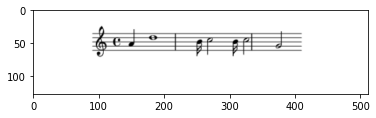

{'boxes': tensor([[146.,  32., 157.,  57.],
        [371.,  35., 381.,  59.],
        [177.,  40., 191.,  47.],
        [266.,  43., 275.,  69.],
        [250.,  46., 260.,  71.],
        [305.,  46., 314.,  71.],
        [321.,  43., 331.,  68.]], device='cuda:0'), 'labels': tensor([6, 9, 7, 8, 7, 8, 5], device='cuda:0'), 'image_id': tensor([10], device='cuda:0'), 'area': tensor([ 11400., 108192.,  19728.,  45938.,  38556.,  62937.,  73114.],
       device='cuda:0'), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0], device='cuda:0')}


In [83]:
#inst_trainloader, inst_testloader = get_random_sheetmusic_loaders()
inst_trainloader, inst_testloader = get_lilypond_loaders()

print('inst_trainloader size =', len(inst_trainloader))
print('inst_testloader size =', len(inst_testloader))

images, targets = next(iter(inst_trainloader))

# Just test that the dataset is formatted properly
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)

print('images[0] shape=', images[0].shape)
output = model(images[0].unsqueeze(0), targets)
print(output)
# For inference
model.eval()
x = [torch.rand(3, 300, 400, device=device), torch.rand(3, 500, 400, device=device)]
predictions = model(x)           # Returns dummy predictions
print(predictions)

for (image, target) in zip(images, targets):
  print('here\'s a sample from the training set:')
  print(f'- image {target["image_id"].item()}:')
  plt.imshow(image.permute(1,2,0).cpu())
  plt.show()
  print(target)

#### Train

In [12]:
# train the object detection network

print('training', regions_net.__class__.__name__, 'model on', device)

regions_net_optimizer = optim.SGD(regions_net.parameters(), lr=lr, momentum=momentum)
regions_net_lr_scheduler = torch.optim.lr_scheduler.StepLR(regions_net_optimizer,
                                                            step_size=40,
                                                            gamma=0.2)

for epoch in range(100):
  engine.train_one_epoch(regions_net, regions_net_optimizer, inst_trainloader, device, epoch, 10)
  # update the learning rate
  regions_net_lr_scheduler.step()
  engine.evaluate(regions_net, inst_testloader, device)
  model_file = f'regions_model.pth'
  torch.save(regions_net.state_dict(), model_file)
  print('\nSaved model to ' + model_file + '.')

training FasterRCNN model on cuda
Epoch: [0]  [ 0/66]  eta: 0:00:40  lr: 0.000164  loss: 3.3449 (3.3449)  loss_classifier: 2.5889 (2.5889)  loss_box_reg: 0.0024 (0.0024)  loss_objectness: 0.7169 (0.7169)  loss_rpn_box_reg: 0.0368 (0.0368)  time: 0.6149  data: 0.0039  max mem: 3428
Epoch: [0]  [10/66]  eta: 0:00:32  lr: 0.001701  loss: 2.2847 (2.1957)  loss_classifier: 1.5746 (1.4955)  loss_box_reg: 0.0165 (0.0148)  loss_objectness: 0.6701 (0.6554)  loss_rpn_box_reg: 0.0254 (0.0300)  time: 0.5720  data: 0.0030  max mem: 4004
Epoch: [0]  [20/66]  eta: 0:00:26  lr: 0.003238  loss: 0.8596 (1.4811)  loss_classifier: 0.3832 (0.9236)  loss_box_reg: 0.0286 (0.0297)  loss_objectness: 0.5144 (0.5022)  loss_rpn_box_reg: 0.0242 (0.0256)  time: 0.5667  data: 0.0028  max mem: 4004
Epoch: [0]  [30/66]  eta: 0:00:21  lr: 0.004774  loss: 0.4021 (1.1110)  loss_classifier: 0.1626 (0.6770)  loss_box_reg: 0.0391 (0.0340)  loss_objectness: 0.1799 (0.3771)  loss_rpn_box_reg: 0.0194 (0.0230)  time: 0.6065  da

In [99]:
regions_net.load_state_dict(torch.load('regions_model.pth', map_location=device))
regions_net.train()
# regions_net_lr_scheduler = torch.optim.lr_scheduler.StepLR(regions_net_optimizer,
#                                                             step_size=40,
#                                                             gamma=0.2)
for epoch in range(20):
  engine.train_one_epoch(regions_net, regions_net_optimizer, inst_trainloader, device, epoch, 10)
  # update the learning rate
  #regions_net_lr_scheduler.step()
  engine.evaluate(regions_net, inst_testloader, device)
  model_file = f'regions_model.pth'
  torch.save(regions_net.state_dict(), model_file)
  print('\nSaved model to ' + model_file + '.')

Epoch: [0]  [ 0/66]  eta: 0:00:37  lr: 0.000001  loss: 0.0344 (0.0344)  loss_classifier: 0.0044 (0.0044)  loss_box_reg: 0.0279 (0.0279)  loss_objectness: 0.0021 (0.0021)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5722  data: 0.0031  max mem: 5307
Epoch: [0]  [10/66]  eta: 0:00:31  lr: 0.000009  loss: 0.0374 (0.0369)  loss_classifier: 0.0061 (0.0078)  loss_box_reg: 0.0272 (0.0272)  loss_objectness: 0.0004 (0.0018)  loss_rpn_box_reg: 0.0000 (0.0000)  time: 0.5657  data: 0.0027  max mem: 5307
Epoch: [0]  [20/66]  eta: 0:00:26  lr: 0.000018  loss: 0.0349 (0.0491)  loss_classifier: 0.0052 (0.0199)  loss_box_reg: 0.0265 (0.0278)  loss_objectness: 0.0004 (0.0014)  loss_rpn_box_reg: 0.0000 (0.0001)  time: 0.5792  data: 0.0027  max mem: 5307
Epoch: [0]  [30/66]  eta: 0:00:20  lr: 0.000027  loss: 0.0310 (0.0680)  loss_classifier: 0.0057 (0.0319)  loss_box_reg: 0.0265 (0.0324)  loss_objectness: 0.0004 (0.0029)  loss_rpn_box_reg: 0.0000 (0.0007)  time: 0.5800  data: 0.0027  max mem: 5307
Epoch: [

### Visualization

Here is where we visualize the detected images.

In [100]:
# load regions net from disk if we don't have it
regions_net.load_state_dict(torch.load('regions_model.pth', map_location=device))
regions_net.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(


#### generate lilypond instance

In [101]:
#plot bounding boxes on image
import matplotlib.patches as patches

def draw_bboxes(sample, target, title, score=None):
  fig = plt.figure()
  ax = fig.add_subplot(111) 
  for (image, target) in zip(sample, target):
    ax.imshow(image.permute(1,2,0).cpu())
    for i in range(target['boxes'].shape[0]):
      if score is not None and target['scores'][i] < score:
        continue
      ex1 = target['boxes'][i][0]
      ey1 = target['boxes'][i][1]
      ex2 = target['boxes'][i][2]
      ey2 = target['boxes'][i][3]
      rect = patches.Rectangle((ex1,ey1),abs(ex1-ex2),abs(ey1-ey2),linewidth=1,edgecolor='r',fill=False,facecolor='r')
      ax.add_patch(rect)
  plt.title(title)
  plt.show()

In [ ]:
#%config InlineBackend.figure_format = 'retina'

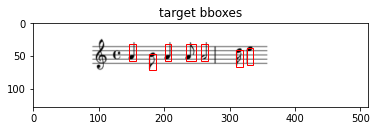

In [121]:
### get lilypond instances
images, targets = next(iter(inst_testloader))
draw_bboxes(images, targets, 'target bboxes')

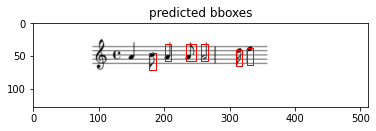

In [122]:
score_threshold = 0.7 # if increase this, some of the boxes with low score will not be selected. So maybe should just remain 0.5?
            # now it seems it can select all the notes in this dataset
regions_net.eval()
#torch.cuda.empty_cache()
predictions = regions_net(images)
draw_bboxes(images, predictions, 'predicted bboxes', score_threshold)

##### lilypond apply CNN

pitch: A4 (staffline: 5)
duration:  Half
(x,y) position in image: (249, 31)


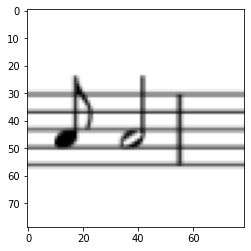

what the classifier sees:


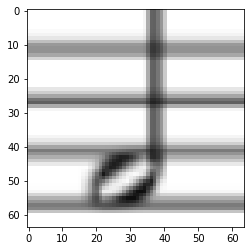


pitch: A4 (staffline: 5)
duration:  Quarter
(x,y) position in image: (193, 31)


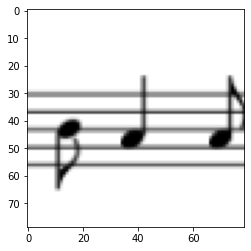

what the classifier sees:


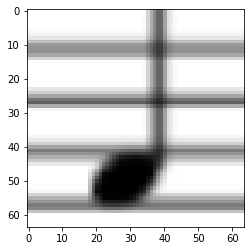


pitch: B5 (staffline: 6)
duration:  Eight
(x,y) position in image: (227, 31)


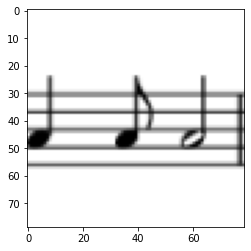

what the classifier sees:


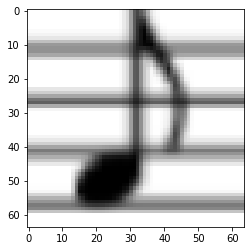


pitch: A4 (staffline: 5)
duration:  Quarter
(x,y) position in image: (317, 37)


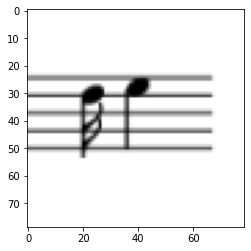

what the classifier sees:


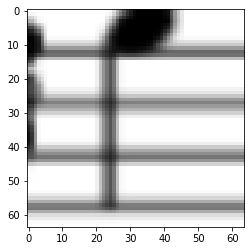


pitch: D5 (staffline: 8)
duration:  Sixteenth
(x,y) position in image: (302, 40)


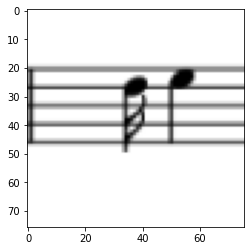

what the classifier sees:


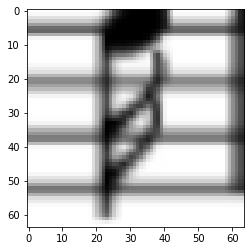


pitch: E5 (staffline: 9)
duration:  Eight
(x,y) position in image: (170, 45)


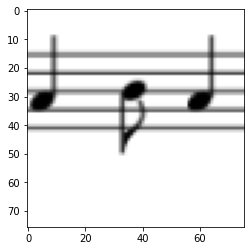

what the classifier sees:


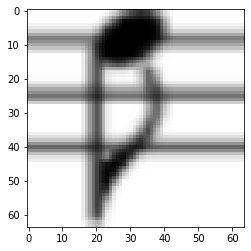


CNN predictions: [{'box': [249, 31, 275, 57], 'pitch': (4, (9, 'A')), 'duration': 1}, {'box': [193, 31, 219, 57], 'pitch': (4, (9, 'A')), 'duration': 2}, {'box': [227, 31, 253, 57], 'pitch': (5, (11, 'B')), 'duration': 0}, {'box': [317, 37, 343, 63], 'pitch': (4, (9, 'A')), 'duration': 2}, {'box': [302, 40, 327, 65], 'pitch': (5, (2, 'D')), 'duration': 3}, {'box': [170, 45, 195, 70], 'pitch': (5, (4, 'E')), 'duration': 0}]


In [123]:
try:
  notes_cnn.eval() # toggle eval mode for Notes CNN
except NameError:
  notes_cnn = NotesCNN().to(device)
  notes_cnn.load_state_dict(torch.load('notes_model.pth', map_location=device))
  notes_cnn.eval()

note_info = []

# print('ODN predictions:', [predictions[0]['boxes'][i] for i in range(predictions[0]['boxes'].shape[0]) if predictions[0]['scores'][i] >= score_threshold])

def staffline_to_pitch(staffline: int):
  """For treble clef only"""
  m = {
      0: (0, 'C'),
      1: (2, 'D'),
      2: (4, 'E'),
      3: (5, 'F'),
      4: (7, 'G'),
      5: (9, 'A'),
      6: (11,'B')
  }

  return (4 + staffline//6, m[staffline % 7])

image = images[0]
for i in range(predictions[0]['boxes'].shape[0]):
  if predictions[0]['scores'][i] < score_threshold:
    continue
  staffline = predictions[0]['labels'][i].item() - 1
  [xmin, ymin, xmax, ymax] = predictions[0]['boxes'][i]
  # convert LilyPond image to NumPy array
  xmin = int(xmin)
  ymin = int(ymin)
  xmax = int(xmax)
  ymax = int(ymax)
  if xmax - xmin < ymax - ymin:
    # expand short dimension to a box
    diff = (ymax - ymin) - (xmax - xmin)
    xmin = max(0, xmin - diff // 2)
    xmax = min(image.shape[2], xmax + (diff - diff//2))
  dim_x = xmax - xmin
  dim_y = ymax - ymin

  #print("image:",image.shape)
  #print(ymin, ymax, xmin, xmax)
  cropped = image[0:3, ymin:ymax+1, xmin:xmax+1]
  #print("cropped:", cropped)
  context = image[0:3, max(0,ymin-dim_y):min(128,ymax+1+dim_y), max(0,xmin-dim_x):min(512,xmax+1+dim_x)]
  #print('cropped shape =', cropped.shape)
  #plt.imshow(cropped.transpose(1,2,0))
  #plt.show()

  temp = np.zeros((3,64,64))
  for c in range(cropped.shape[0]):
    #print("croped c", cropped[c])
    temp[c,:,:] = cv2.resize(cropped[c].cpu().numpy(), (64,64))

  resized = torch.tensor(temp, dtype=torch.float32)

  
  # classify the data (CNN)
  output = notes_cnn(resized.unsqueeze(0).to(device))
  note_cls = output.data.max(1, keepdim=True)[1].item()
  pitch = staffline_to_pitch(staffline)
  note_info.append({
      'box': [xmin, ymin, xmax, ymax],
      'pitch': staffline_to_pitch(staffline),
      'duration': note_cls
  })

  # DEBUG
  print('pitch:', f'{pitch[1][1]}{pitch[0]}', f'(staffline: {staffline})')
  print('duration: ', image_dataset.classes[note_cls])
  print('(x,y) position in image:', (xmin, ymin))
  plt.imshow(context.permute(1,2,0).cpu())
  plt.show()

  print('what the classifier sees:')
  plt.imshow(resized.permute(1,2,0).cpu())
  plt.show()
  print()

print('CNN predictions:', note_info)


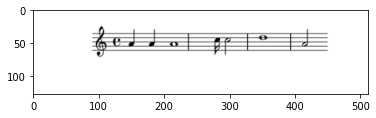

In [72]:
tem_img = cv2.imread('lilypond/pic/sheet_1.png')
plt.imshow(tem_img)

In [ ]:
# Get the list of loss and accuracy per epoch
avg_loss = []
validation_accuracy = []


#### generate random music instance

In [ ]:
#plot bounding boxes on image
import matplotlib.patches as patches

def draw_bboxes_randmusic(sample, target, title, score=None):
  fig = plt.figure()
  ax = fig.add_subplot(111) 
  for (image, target) in zip(sample, target):
    ax.imshow(image.permute(1,2,0).cpu())
    for i in range(target['boxes'].shape[0]):
      if score is not None and target['scores'][i] < score:
        continue
      ex1 = target['boxes'][i][0]
      ey1 = target['boxes'][i][1]
      ex2 = target['boxes'][i][2]
      ey2 = target['boxes'][i][3]
      rect = patches.Rectangle((ex1,ey1),abs(ex1-ex2),abs(ey1-ey2),linewidth=1,edgecolor='r',fill=False,facecolor='r')
      ax.add_patch(rect)
  plt.title(title)
  plt.show()

In [ ]:
# generate instance
def random_music_instance():
  image, bboxes, labels = random_music()
  bboxes = torch.as_tensor(bboxes, dtype=torch.float32, device=device)
  labels = torch.as_tensor(labels, dtype=torch.int64, device=device)

  target = {}
  target['boxes'] = bboxes
  target['labels'] = labels + 1   # RPN has label 0 reserved for background
  target['area'] = (bboxes[:, 3] - bboxes[:, 2]) * (bboxes[:, 1] - bboxes[:, 0])
  target['iscrowd'] = torch.zeros((len(labels),), dtype=torch.int64, device=device)

  return torch.tensor(image, dtype=torch.float32, device=device).permute(2,0,1), target

image, target = random_music_instance()
print(image[0].shape)

torch.Size([128, 256])


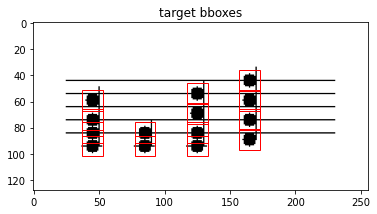

In [ ]:
# draw testing boxes

draw_bboxes_randmusic([image], [target], 'target bboxes')

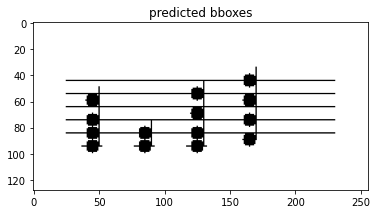

In [ ]:
# draw predicted boxes

score_threshold = 0.5
regions_net.eval()
#torch.cuda.empty_cache()
predictions = regions_net([image])
draw_bboxes_randmusic([image], predictions, 'predicted bboxes', score_threshold)

### Classify Detected Notes

For each detected note, blow up the region and run it through the classifier.

In [ ]:
try:
  notes_cnn.eval() # toggle eval mode for Notes CNN
except NameError:
  notes_cnn = NotesCNN().to(device)
  notes_cnn.load_state_dict(torch.load('notes_model_20.pth', map_location=device))
  notes_cnn.eval()

note_info = []

# print('ODN predictions:', [predictions[0]['boxes'][i] for i in range(predictions[0]['boxes'].shape[0]) if predictions[0]['scores'][i] >= score_threshold])

def staffline_to_pitch(staffline: int):
  """For treble clef only"""
  m = {
      0: (0, 'C'),
      1: (2, 'D'),
      2: (4, 'E'),
      3: (5, 'F'),
      4: (7, 'G'),
      5: (9, 'A'),
      6: (11,'B')
  }

  return (4 + staffline//6, m[staffline % 7])

for i in range(predictions[0]['boxes'].shape[0]):
  if predictions[0]['scores'][i] < score_threshold:
    continue
  staffline = predictions[0]['labels'][i].item() - 1
  [xmin, ymin, xmax, ymax] = predictions[0]['boxes'][i]
  xmin = int(xmin)
  ymin = int(ymin)
  xmax = int(xmax)
  ymax = int(ymax)
  cropped = image.cpu().numpy()[0:3, ymin:ymax+1, xmin:xmax+1]
  temp = []
  for c in range(cropped.shape[0]):
    temp.append(cv2.resize(cropped[c].astype(np.float32), (64,64)))
  resized = torch.tensor(np.asarray(temp), dtype=torch.float32)
  
  output = notes_cnn(resized.unsqueeze(0).to(device))
  note_cls = output.data.max(1, keepdim=True)[1].item()
  pitch = staffline_to_pitch(staffline)
  note_info.append({
      'box': [xmin, ymin, xmax, ymax],
      'pitch': staffline_to_pitch(staffline),
      'duration': note_cls
  })

  # DEBUG
  print('pitch:', f'{pitch[1][1]}{pitch[0]}', f'(staffline: {staffline})')
  print('duration: ', image_dataset.classes[note_cls])
  print('(x,y) position in image:', (xmin, ymin))
  plt.imshow(resized.permute(1,2,0))
  plt.show()

print('CNN predictions:', note_info)


NameError: ignored

### another object detection dataset (unused)

Note: this has many examples and training is very, very slow.

In [ ]:
# load dataset for object detection

import json

instance_data = []

with open('Regions/deepscores_train.json') as f:
  obj = json.load(f)
  categories, images, annotations = obj['categories'], obj['images'], obj['annotations']

  instance_categories = []
  seen_categories = {}
  limit = 5000

  for image in images:
    if len(instance_data) >= limit:
      break
    for ann_id in image['ann_ids']:
      if len(instance_data) >= limit:
        break
      category = categories[annotations[ann_id]['cat_id'][0]]['name']

      # cat_id = int(annotations[ann_id]['cat_id'][0])
      cat_id = None
      # map category to category for notes dataset
      if category.startswith('noteheadBlack'):  # quarter note?
        cat_id = image_dataset.class_to_idx['Quarter']
      elif category.startswith('noteheadHalf'):
        cat_id = image_dataset.class_to_idx['Half']
      elif category.startswith('noteheadWhole'): # or category.startswith('noteheadDoubleWhole') ?
        cat_id = image_dataset.class_to_idx['Whole']

      if cat_id is not None:
        if image_dataset.classes[cat_id] not in seen_categories:
          seen_categories[image_dataset.classes[cat_id]] = set()
        seen_categories[image_dataset.classes[cat_id]].add(category)
        instance_data.append((image['filename'], annotations[ann_id]['a_bbox'], int(cat_id)))

def recombine_object_detection_data(data):
  """
  To be used within a data loader.
  """
  files = {}
  for (filename, bounding_box, class_id) in data:
    if not filename in files:
      files[filename] = {'bounding_box': [], 'label': []}
    files[filename]['bounding_box'].append(bounding_box)
    files[filename]['label'].append(class_id)
  return files

print('there are', len(instance_data), 'boxes and', len(seen_categories), 'object categories')
print('object categories:', seen_categories)

num_test_instances = int(len(instance_data) * train_fraction)
train_instance_data, test_instance_data = torch.utils.data.random_split(instance_data, [num_test_instances, len(instance_data) - num_test_instances])

print('will train with', len(train_instance_data), 'and test with', len(test_instance_data))

class NotesDetectionSet(torch.utils.data.Dataset):
  def __init__(self, data):
    self.images = list(recombine_object_detection_data(data).items())
    #self.transforms = T.Compose([T.ToTensor()])
  
  def __getitem__(self, idx):
    image_basename, image_metadata = self.images[idx]
    image = PIL.Image.open(f'Regions/images/{image_basename}')

    bboxes = torch.as_tensor(image_metadata['bounding_box'], dtype=torch.float32, device=device)
    labels = torch.as_tensor(image_metadata['label'], dtype=torch.int64, device=device)

    target = {}
    target['boxes'] = bboxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([idx], device=device)
    target['area'] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
    target['iscrowd'] = torch.zeros((len(labels),), dtype=torch.int64, device=device)

    return torch.tensor(np.asarray(image), dtype=torch.float32, device=device).permute(2,0,1), target
  
  def __len__(self):
    return len(self.images)

def get_sheetmusic_loaders():
  train_dt = NotesDetectionSet(train_instance_data)
  test_dt = NotesDetectionSet(test_instance_data)
  train_loader = torch.utils.data.DataLoader(train_dt,
                                             batch_size=1,
                                             shuffle=True,
                                             num_workers=0,
                                             collate_fn=utils.collate_fn)
  val_loader = torch.utils.data.DataLoader(test_dt,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=0,
                                           collate_fn=utils.collate_fn)

  return train_loader, val_loader

FileNotFoundError: ignored

inst_trainloader size = 23
inst_testloader size = 23
here's a sample from the training set:
- the image:


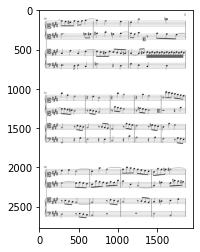

{'bounding_box': tensor([[[ 280.,  542.,  300.,  560.],
         [1086.,  542., 1106.,  560.],
         [ 728.,  288.,  748.,  305.],
         [ 584.,  296.,  604.,  313.],
         [1833.,  534., 1853.,  551.],
         [ 983.,  534., 1003.,  551.],
         [1350., 1256., 1370., 1273.],
         [1462.,  534., 1482.,  551.],
         [ 441.,  130.,  461.,  147.],
         [ 837.,  130.,  859.,  147.],
         [ 837.,  271.,  857.,  289.],
         [ 645.,  296.,  665.,  313.],
         [ 728.,  122.,  748.,  139.],
         [1493.,  526., 1513.,  543.],
         [ 837.,  534.,  857.,  551.],
         [ 584.,  122.,  604.,  139.],
         [ 489.,  138.,  509.,  156.],
         [ 776.,  526.,  796.,  543.],
         [ 280.,  692.,  300.,  709.],
         [1031.,  138., 1051.,  156.],
         [1276., 1240., 1296., 1257.],
         [ 728.,  675.,  750.,  693.],
         [1505., 1469., 1525., 1486.],
         [ 328.,  138.,  348.,  156.],
         [ 280.,  296.,  302.,  313.],
        

In [ ]:
# music notes detection set (version 2)
class NotesDetectionSet(torch.utils.data.Dataset):
  def __init__(self, data):
    files = recombine_object_detection_data(data)
    
    self.data = []

    for filename, data in files.items():
      image = PIL.Image.open('Regions/images/' + filename)
      # XXX: should we crop?
      if image.size == (1960, 2772):
        self.data.append({'image': image, 'data': data})

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx]['image']
    target = {}
    target['bounding_box'] = torch.tensor(self.data[idx]['data']['bounding_box'])
    target['label'] = torch.tensor(self.data[idx]['data']['label'])
    return torch.tensor(np.asarray(image)).permute(2,0,1), target

def get_shapes_loader():
  train_dt = NotesDetectionSet(train_instance_data)
  test_dt = NotesDetectionSet(test_instance_data)
  train_loader = torch.utils.data.DataLoader(train_dt, batch_size=1, shuffle=True, num_workers=0)
  val_loader = torch.utils.data.DataLoader(test_dt, batch_size=1, shuffle=True, num_workers=0)

  return train_loader, val_loader

inst_trainloader, inst_testloader = get_shapes_loader()

print('inst_trainloader size =', len(inst_trainloader))
print('inst_testloader size =', len(inst_testloader))
sample, target = iter(inst_trainloader).next()

print('here\'s a sample from the training set:')
print('- the image:')
plt.imshow(sample.flatten(0, 1).permute(1, 2, 0))
plt.show()

print(target)

### Cleanup

In [ ]:
# cleanup

if mounted:
  drive.flush_and_unmount()
  print('unmounted Google Drive')

unmounted Google Drive
